In [49]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
crime_chicago = pd.read_pickle('crime_chicago_with_timestamp.pkl')

In [3]:
crime_chicago.head(1)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,day,datetime
0,10361459,HY553232,12/28/2015 11:39:00 PM,025XX S STEWART AVE,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,...,18,50629,72523,2015,01/04/2016 04:02:14 PM,41.845652,-87.636561,"(41.845652363, -87.636561415)",12/28/2015,2015-12-28


### Manipulating data

Binning the data with the size of the bin equal `bin_size`

In [4]:
number_of_bins = 70
no = number_of_bins

lat_min = crime_chicago['Latitude'].min()
lon_min = crime_chicago['Longitude'].min()

lat_span = crime_chicago['Latitude'].max() - crime_chicago['Latitude'].min()
lon_span = crime_chicago['Longitude'].max() - crime_chicago['Longitude'].min()

lat_step = lat_span / no
lon_step = lon_span / no

In [5]:
crime_chicago['bin'] = \
    no*np.floor((crime_chicago['Longitude']-lon_min)/lon_step) + \
       np.floor((crime_chicago['Latitude'] -lat_min)/lat_step)

In [6]:
def getPolygonForBin(bin_no):
    lat, lon = getCornerLatLonForBin(bin_no)
    return Polygon([
            (lat,            lon),
            (lat,            lon + lon_step),
            (lat + lat_step, lon + lon_step),
            (lat + lat_step, lon),
        ])

In [7]:
def getPolygonForBinReverse(bin_no):
    lat, lon = getCornerLatLonForBin(bin_no)
    return Polygon([
            (lon,            lat),
            (lon + lon_step, lat),
            (lon + lon_step, lat + lat_step),
            (lon,            lat + lat_step),
        ])

#### Grouping

In [8]:
crime_chicago['datetime'].head(1)

0   2015-12-28
Name: datetime, dtype: datetime64[ns]

In [9]:
crime_chicago.index = pd.DatetimeIndex(crime_chicago['datetime'])

In [10]:
crime_chicago_count = crime_chicago[['bin', 'datetime']].groupby(['bin', 'datetime']).size().reset_index().rename(columns={0:'count'})

In [11]:
crime_chicago_count['count'].describe()

count    3964836.000000
mean           1.474636
std            0.974173
min            1.000000
25%            1.000000
50%            1.000000
75%            2.000000
max          150.000000
Name: count, dtype: float64

In [12]:
crime_chicago_count.index = pd.DatetimeIndex(crime_chicago_count['datetime'])

In [13]:
crime_chicago_count.head(1)

,bin,datetime,count
2001-01-23,54,2001-01-23,1


### Importing weather data

In [14]:
weather_chicago = pd.read_csv('WeatherChicago20012016.csv')

In [15]:
def weather_date_to_datetime(date):
#     print date[0:4], date[6:], date[4:6]
    return pd.datetime(int(date[0:4]), int(date[4:6]), int(date[6:]))

In [16]:
weather_chicago['DATE'] = weather_chicago['DATE'].map(lambda x: weather_date_to_datetime(str(x)))

In [17]:
weather_chicago.index = pd.DatetimeIndex(weather_chicago['DATE'])

In [18]:
tmin_mean = weather_chicago['TMIN'].mean()
tmax_mean = weather_chicago['TMAX'].mean()

weather_chicago.loc[weather_chicago['TMIN'] == -9999, ['TMIN']] = tmin_mean
weather_chicago.loc[weather_chicago['TMAX'] == -9999, ['TMAX']] = tmax_mean
weather_chicago.loc[weather_chicago['PRCP'] == -9999, ['PRCP']] = 0
weather_chicago.loc[weather_chicago['AWND'] == -9999, ['AWND']] = 0

In [19]:
weather_chicago.describe()

,Unnamed: 0,PRCP,TMAX,TMIN,AWND
count,5516.000000,5516.000000,5516.000000,5516.000000,5516.000000
mean,304087.500000,23.614757,154.871838,65.567674,43.406454
std,1592.476373,69.814114,117.308374,106.125744,16.127364
min,301330.000000,0.000000,-182.000000,-277.000000,0.000000
25%,302708.750000,0.000000,56.000000,-11.000000,32.000000
50%,304087.500000,0.000000,167.000000,67.000000,42.000000
75%,305466.250000,8.000000,261.000000,161.000000,53.000000
max,306845.000000,1201.000000,400.000000,283.000000,125.000000


In [20]:
weather_chicago.head(2)

,Unnamed: 0,STATION_NAME,DATE,PRCP,TMAX,TMIN,AWND
2001-01-01,301330,CHICAGO MIDWAY AIRPORT IL US,2001-01-01,0,-33,-106,33
2001-01-02,301331,CHICAGO MIDWAY AIRPORT IL US,2001-01-02,0,-67,-139,39


### Concatenating crimes and weather

In [21]:
crime_chicago_count_ref = crime_chicago[['datetime']].groupby(['datetime']).size().reset_index().rename(columns={0:'count'})
crime_chicago_count_ref.index = pd.DatetimeIndex(crime_chicago_count_ref['datetime'])
crime_chicago_count_ref.head(1)

,datetime,count
2001-01-01,2001-01-01,1715


In [22]:
crime_chicago_count_weather = crime_chicago_count_ref.join(weather_chicago[['PRCP', 'TMAX','AWND']])

In [23]:
crime_chicago_count_weather.head(1)

,datetime,count,PRCP,TMAX,AWND
2001-01-01,2001-01-01,1715,0,-33,33


#### Finding empty records

In [24]:
indeces = pd.isnull(crime_chicago_count_weather).any(1)
crime_chicago_count_weather.drop(crime_chicago_count_weather.index[indeces], inplace=True)
len(crime_chicago_count_weather)

5470

## Trying to predict 

In [50]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats.stats import pearsonr

In [26]:
crime_chicago_count_weather.describe()

,count,PRCP,TMAX,AWND
count,5470.000000,5470.000000,5470.000000,5470.000000
mean,1067.889945,23.745887,156.084288,43.373675
std,237.261160,70.040125,116.958562,16.131466
min,313.000000,0.000000,-182.000000,0.000000
25%,882.250000,0.000000,61.000000,32.000000
50%,1089.000000,0.000000,167.000000,42.000000
75%,1264.750000,8.000000,261.000000,53.000000
max,1794.000000,1201.000000,400.000000,125.000000


In [27]:
crime_chicago_count_weather['ones'] = crime_chicago_count_weather.loc[:,['count']]
crime_chicago_count_weather.loc[:,['ones']] = 1
dta = crime_chicago_count_weather

In [28]:
res = smf.glm('count~TMAX', data=dta, 
                family=sm.families.Poisson(link=sm.families.links.log)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                 5470
Model:                            GLM   Df Residuals:                     5468
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -1.5414e+05
Date:                Thu, 18 Feb 2016   Deviance:                   2.6024e+05
Time:                        16:13:01   Pearson chi2:                 2.51e+05
No. Iterations:                    10                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.8604      0.001   9488.133      0.000         6.859     6.862
TMAX           0.0007   3.58e-06    196.264      0.000         0.001     0.001
==============================================================================
"""

In [53]:
res = smf.glm('count~TMAX', data=dta, 
                family=sm.families.Poisson(link=sm.families.links.log)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                 5470
Model:                            GLM   Df Residuals:                     5468
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -1.5414e+05
Date:                Thu, 18 Feb 2016   Deviance:                   2.6024e+05
Time:                        16:23:49   Pearson chi2:                 2.51e+05
No. Iterations:                    10                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.8604      0.001   9488.133      0.000         6.859     6.862
TMAX           0.0007   3.58e-06    196.264      0.000         0.001     0.001
==============================================================================
"""

In [29]:
nobs = res.nobs
yhat = res.mu

In [30]:
from statsmodels.graphics.api import abline_plot

In [39]:
y = crime_chicago_count_weather.loc[:,'count']

In [40]:
len(y)

5470

In [41]:
len(yhat)

5470

In [56]:
yhat[:] = crime_chicago_count_weather['count'].mean()

In [57]:
yhat

array([ 1067.88994516,  1067.88994516,  1067.88994516, ...,  1067.88994516,
        1067.88994516,  1067.88994516])

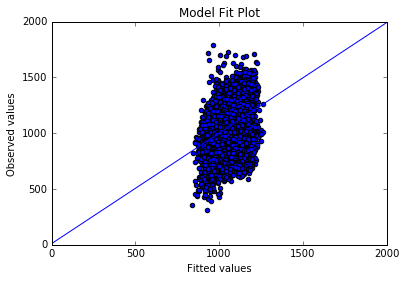

In [51]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)

plt.axis([0, 2000, 0, 2000])

ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

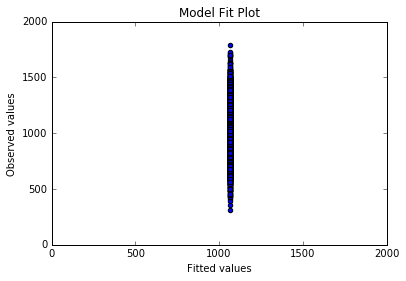

In [60]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
# abline_plot(model_results=1, ax=ax)

plt.axis([0, 2000, 0, 2000])

ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');